# Markowitz Portfolio Optimization with Python

By Daniel Kerim Acatay

In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
#import xarray as xr
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot styling
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

# Introduction

In this Notebook we will build some tools for the evaulation of the risk and return of a real asset portfolio. As allways this notebook will feature a large amount of information in a short time and all required resources to understand the topics are linked in the Resources or within the correpsonding Parts.


# Part 1: Download Economic Time Series

Use <code>pandas_datareader</code> to access the API of financial data providers like Yahhoo! Finance, Google Finance, or the Fred.

In [121]:
# define data to be downloaded
tickers = list(pd.read_csv('./data/SP100_LIST.csv', sep=';')['Symbol'])
provider = 'yahoo'
start = '2010-01-01'
end = '2017-11-14'

In [124]:
# download data
data = web.DataReader(tickers, provider, start)['Adj Close']
data.to_csv('data/data_sp100.csv', sep=';')

In [169]:
# read data from file
data = pd.read_csv('./data/data_sp100.csv', sep=';', index_col=0, header=0, parse_dates=True)

In [170]:
companies = ['GOOGL', 'MSFT', 'AMZN', 'AAPL', 'WMT', 'PG', 'GM']

In [171]:
# calculate log returns
returns = data[companies] / data[companies].shift(1) - 1
returns = returns.fillna(method='ffill').dropna()

In [172]:
returns

,GOOGL,MSFT,AMZN,AAPL,WMT,PG,GM
Date,,,,,,,
2010-11-19,-0.00961,-0.00580,0.00396,-0.00551,0.00760,0.00047,0.00205
2010-11-22,0.00066,0.00156,0.03379,0.02162,-0.00018,-0.00765,-0.00525
2010-11-23,-0.01389,-0.02371,-0.01285,-0.01478,-0.01306,-0.01495,-0.02435
2010-11-24,0.02051,0.00995,0.05381,0.01966,0.00634,-0.00016,0.00692
2010-11-26,-0.00835,-0.00473,-0.00028,0.00064,-0.00500,-0.00751,0.00956
2010-11-29,-0.01337,0.00238,0.01292,0.00594,0.00205,0.00000,0.00000
2010-11-30,-0.04535,-0.00198,-0.02279,-0.01805,0.00446,-0.01706,0.01183
2010-12-01,0.01555,0.03088,0.00656,0.01687,0.01128,0.01768,0.01696
...,...,...,...,...,...,...,...


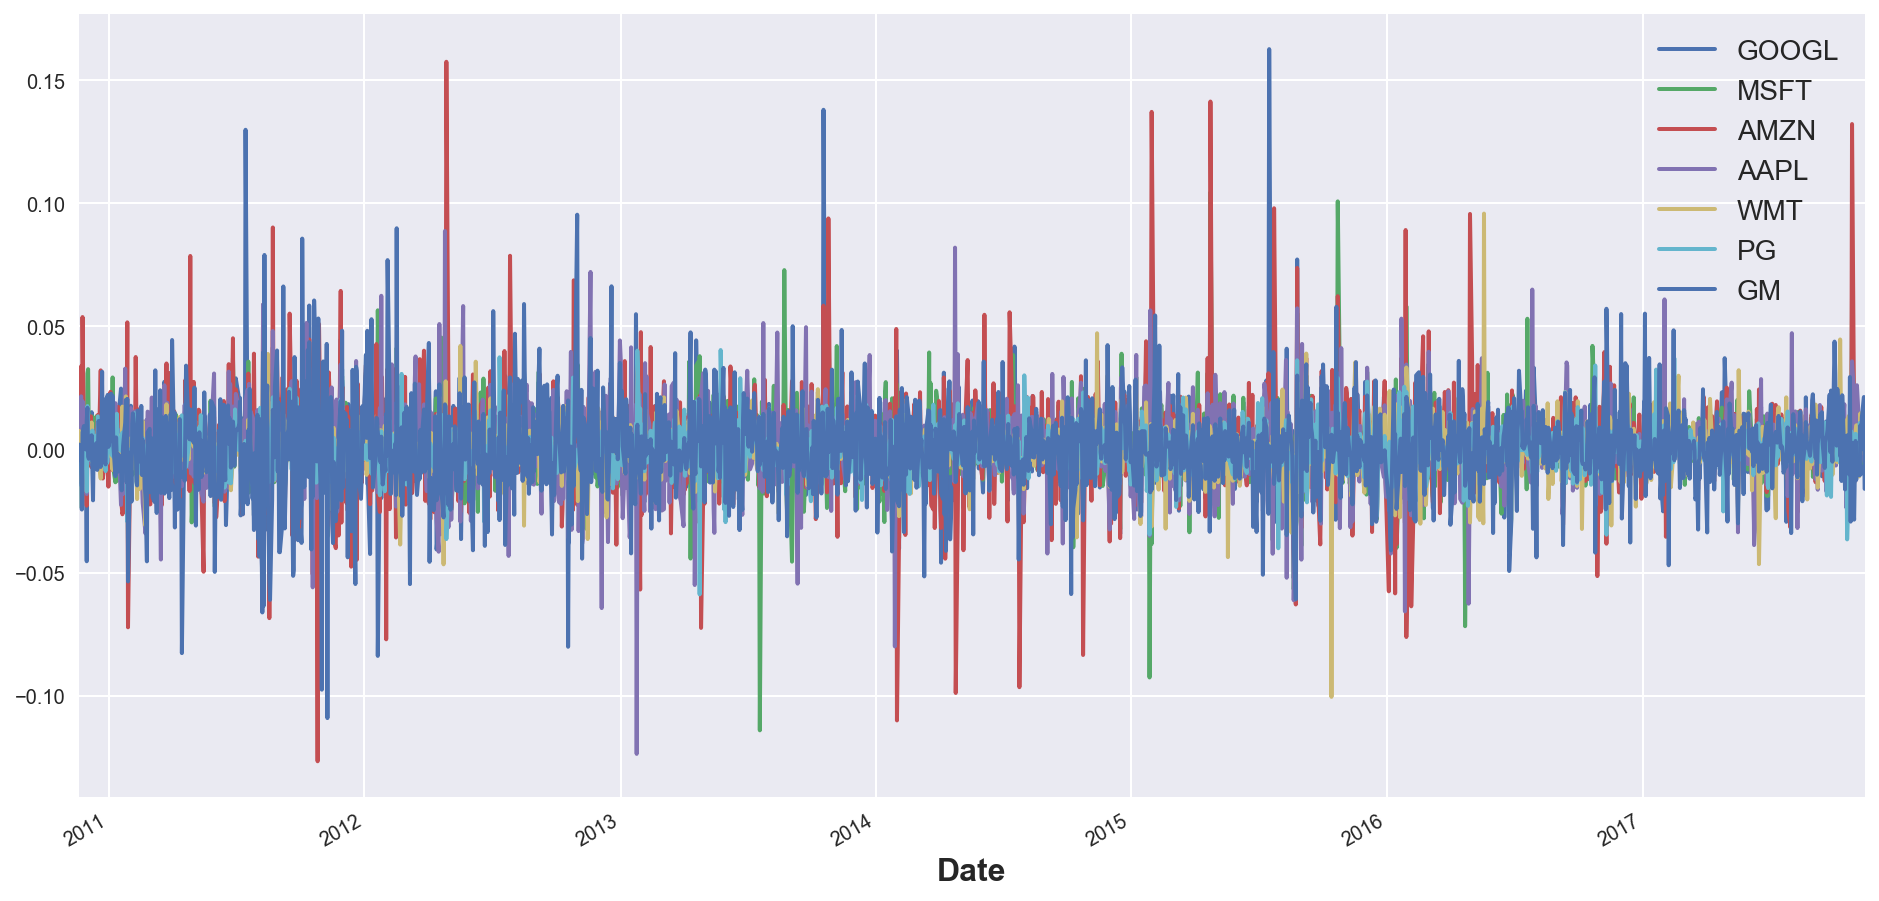

In [143]:
returns.plot()
plt.show()

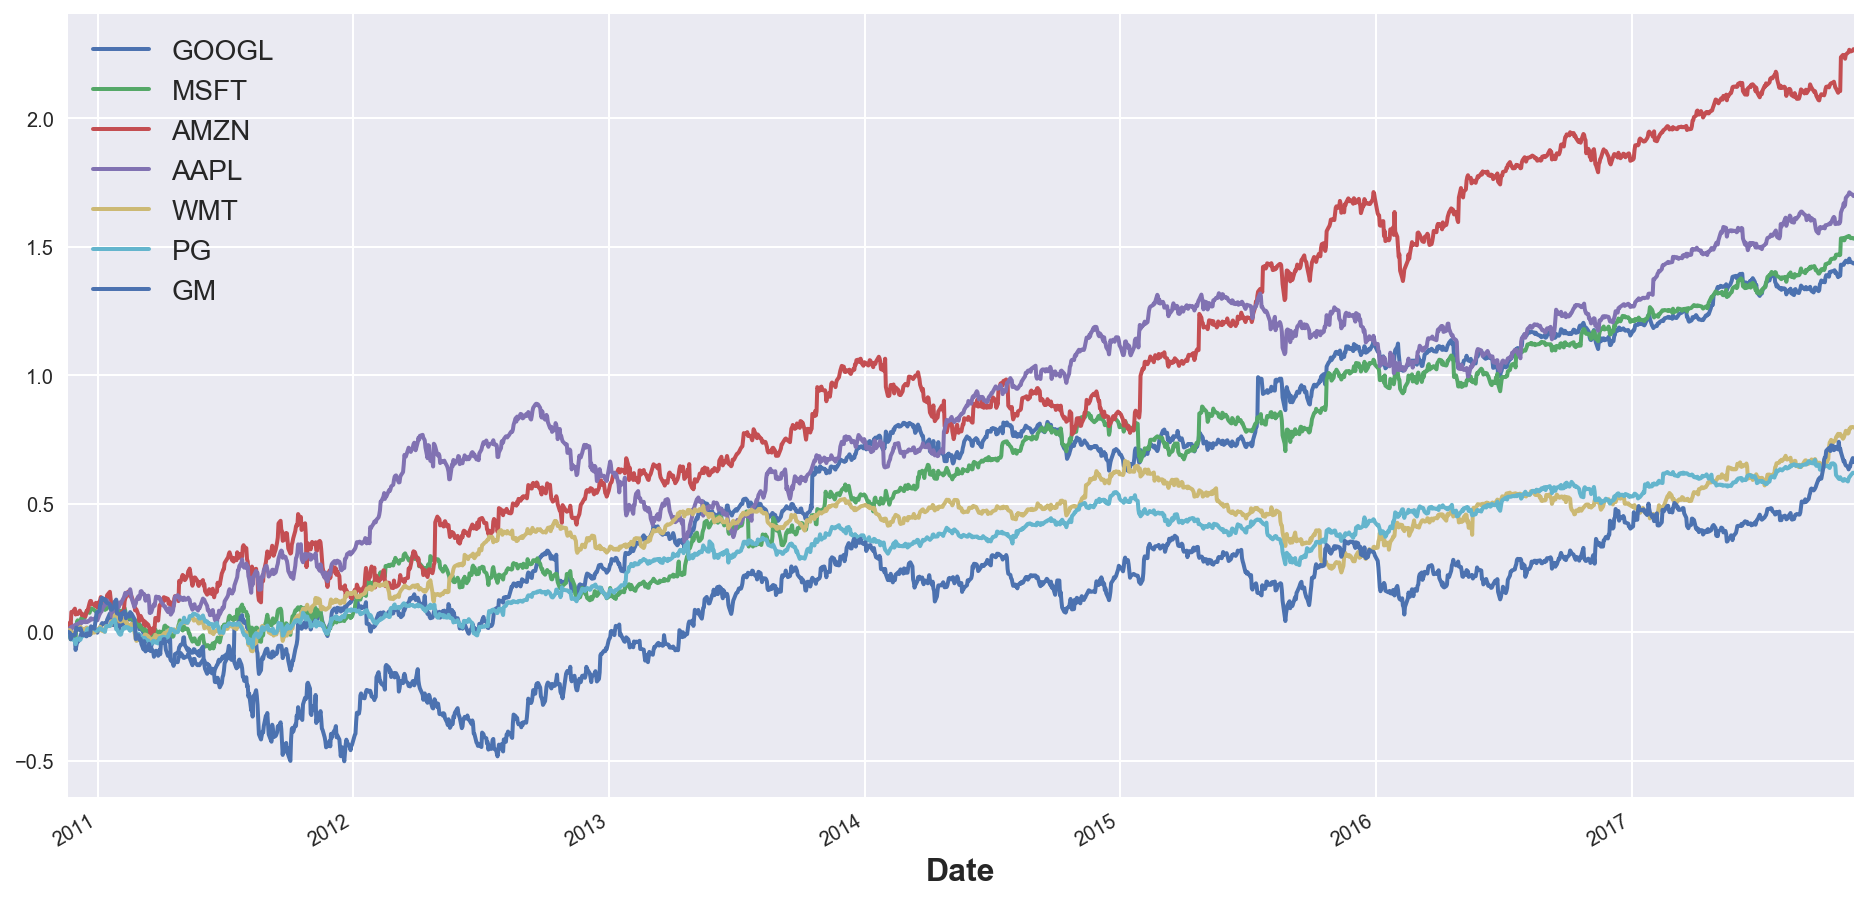

In [144]:
returns.cumsum().plot()
plt.show()

In [145]:
# calculate monthly returns by resampling the series
monthly_returns = data.resample('BM', how=lambda x: (x[-1]/x[0])-1)

# Part 2: Modern Portfolio Theory with Python

<a href="https://en.wikipedia.org/wiki/Modern_portfolio_theory">**Modern portfolio theory (MPT)**</a>, or **mean-variance analysis**, introduced by **Harry Markowitz**, is a mathematical framework for assembling a portfolio of assets such that the expected return is maximized for a given level of risk, defined as variance. Its key insight is that an asset's risk and return should not be assessed by itself, but by how it contributes to a portfolio's overall risk and return.

The MPT assumes that investors are rational and risk averse. That is, given two portfolios that offer the same expected return, investors will prefer the less risky one. Thus, an investor will take on increased risk only if compensated by higher expected returns. Conversely, an investor who wants higher expected returns must accept more risk. 

In a perfect market the trade-off will be exactely the same for all investors, but different investors will evaluate the trade-off differently in accordance to their risk appetite. 

## Expected Portfolio Risk and Return

Consider an asset portfolio consisting of $i=1, \dots, N$ assets. Let $R_i$ denote the return on asset $i$ and expect that the following holds:

\begin{align}
R_i \ &\sim{iid} \ \mathcal{N}(\mu_i, \sigma_i^2) \\
\text{cov}(R_i, R_j) & = \sigma_{ij}
\end{align}


If we are interested in the comparative performance of a portfolio we need to consider the volatility of the stocks within it. The portfolio variance is calcualted as

$$
\sigma_p^2 = \sum_i \omega_i^2 \sigma_i^2 + \sum_i \sum_{j \neq i} \omega_i \omega_j \sigma_i \sigma_j \rho_{ij}
$$
where
*
*
* $\sigma_i \sigma_j \rho_{ij} = \sigma_{ij}$ is the correlation coefficient
For the case of a portfolio with two assets we can simplify to


## Portfolio Characteristics with Matrix Algebra

Let the following $N \times 1$ vectors contain the asset returns and portfolio weights

$$
\textbf{R} = 
\begin{bmatrix}
R_1 \\
R_2 \\
\vdots \\
R_N \\
\end{bmatrix}, \quad
\mathbf{\omega} = 
\begin{bmatrix}
\omega_1 \\
\omega_2 \\
\vdots \\
\omega_N \\
\end{bmatrix},
$$

Under the $iid$ normality assumption all returns are jointly normally distributed and this joint distribution is completely characterized by the means, variances and covariances of the returns. The expected value and the variance-covariance matrix of the portfolio can be found by

$$
E[\textbf{R}] = E 
\begin{bmatrix}
R_1 \\
R_2 \\
\vdots \\
R_N \\
\end{bmatrix} =
\begin{bmatrix}
E[R_1] \\
E[R_2] \\
\vdots \\
E[R_N] \\
\end{bmatrix}  =
\begin{bmatrix}
\mu_1 \\
\mu_2 \\
\vdots \\
\mu_N \\
\end{bmatrix} = \mathbf{\mu}, \quad
\Sigma = 
\begin{bmatrix}
\sigma_{11} & \sigma_{12} & \cdots & \sigma_{1N} \\
\sigma_{21} & \sigma_{22} & \cdots & \sigma_{2N} \\
\vdots & \vdots & \ddots & \vdots\\
\sigma_{N1} & \sigma_{N2} & \cdots & \sigma_{NN} \\
\end{bmatrix}.
$$

The portfolio return $R$ and variance $\sigma^2$ are calculated by:

\begin{align}
R & = \omega^T \mu \\
\sigma^2 & = \omega^T \Sigma \omega
\end{align}


## Building Available Market Portfolios

We start our analysis by generating random data series which will mimick the return behavior of actual financial assets.

In [146]:
np.random.seed(1)

# length of artificial time series
n_obs = 1000

# number of different assets
n_assets = 4

return_vec = np.random.randn(n_obs, n_assets) + 0.05
return_vec_df = pd.DataFrame(return_vec)
return_vec

array([[ 1.67435, -0.56176, -0.47817, -1.02297],
       [ 0.91541, -2.25154,  1.79481, -0.71121],
       [ 0.36904, -0.19937,  1.51211, -2.01014],
       ..., 
       [ 0.12342,  0.46603, -1.8292 ,  0.62546],
       [ 0.15206,  1.2343 , -0.74484, -0.0759 ],
       [-0.91035, -0.79391,  0.67834,  0.58721]])

We the following functions we will create random portfolio weights which will be used to construct a randomly weightes portfolio from the included returns series. for these randomly created portfolios we will calculate the means and standard deviation

In [147]:
def create_portfolio_weights(n_assets):
    '''
    returns randomly choosen portfolio weights that sum to one
    '''
    w = np.random.rand(n_assets)
    return w / w.sum()

In [204]:
def evaluate_portfolio(returns):
    ''' 
    returns the mean and standard deviation of returns for a random portfolio
    '''
    # in case a resampler is used
    returns = pd.DataFrame(returns)   
    
    # calculate from input series
    cov = np.matrix(returns.cov())
    R = np.matrix(returns.mean())
    w = np.matrix(create_portfolio_weights(returns.shape[1]))
    
    #calculate expected portfolio return and risk
    mu = w * R.T
    sigma = np.sqrt(w * cov * w.T)
    
    return mu, sigma

In [205]:
def create_random_portfolios(returns, n_portfolios=1500):
    '''
    plots randomly created portfolios
    '''
    # calculate mean and std for every portfolio
    pf_mus, pf_sigmas = np.column_stack([evaluate_portfolio(returns) for _ in range(n_portfolios)])

    return pf_mus, pf_sigmas

In [206]:
pf_mus, pf_sigmas = create_random_portfolios(return_vec, n_portfolios=3000)

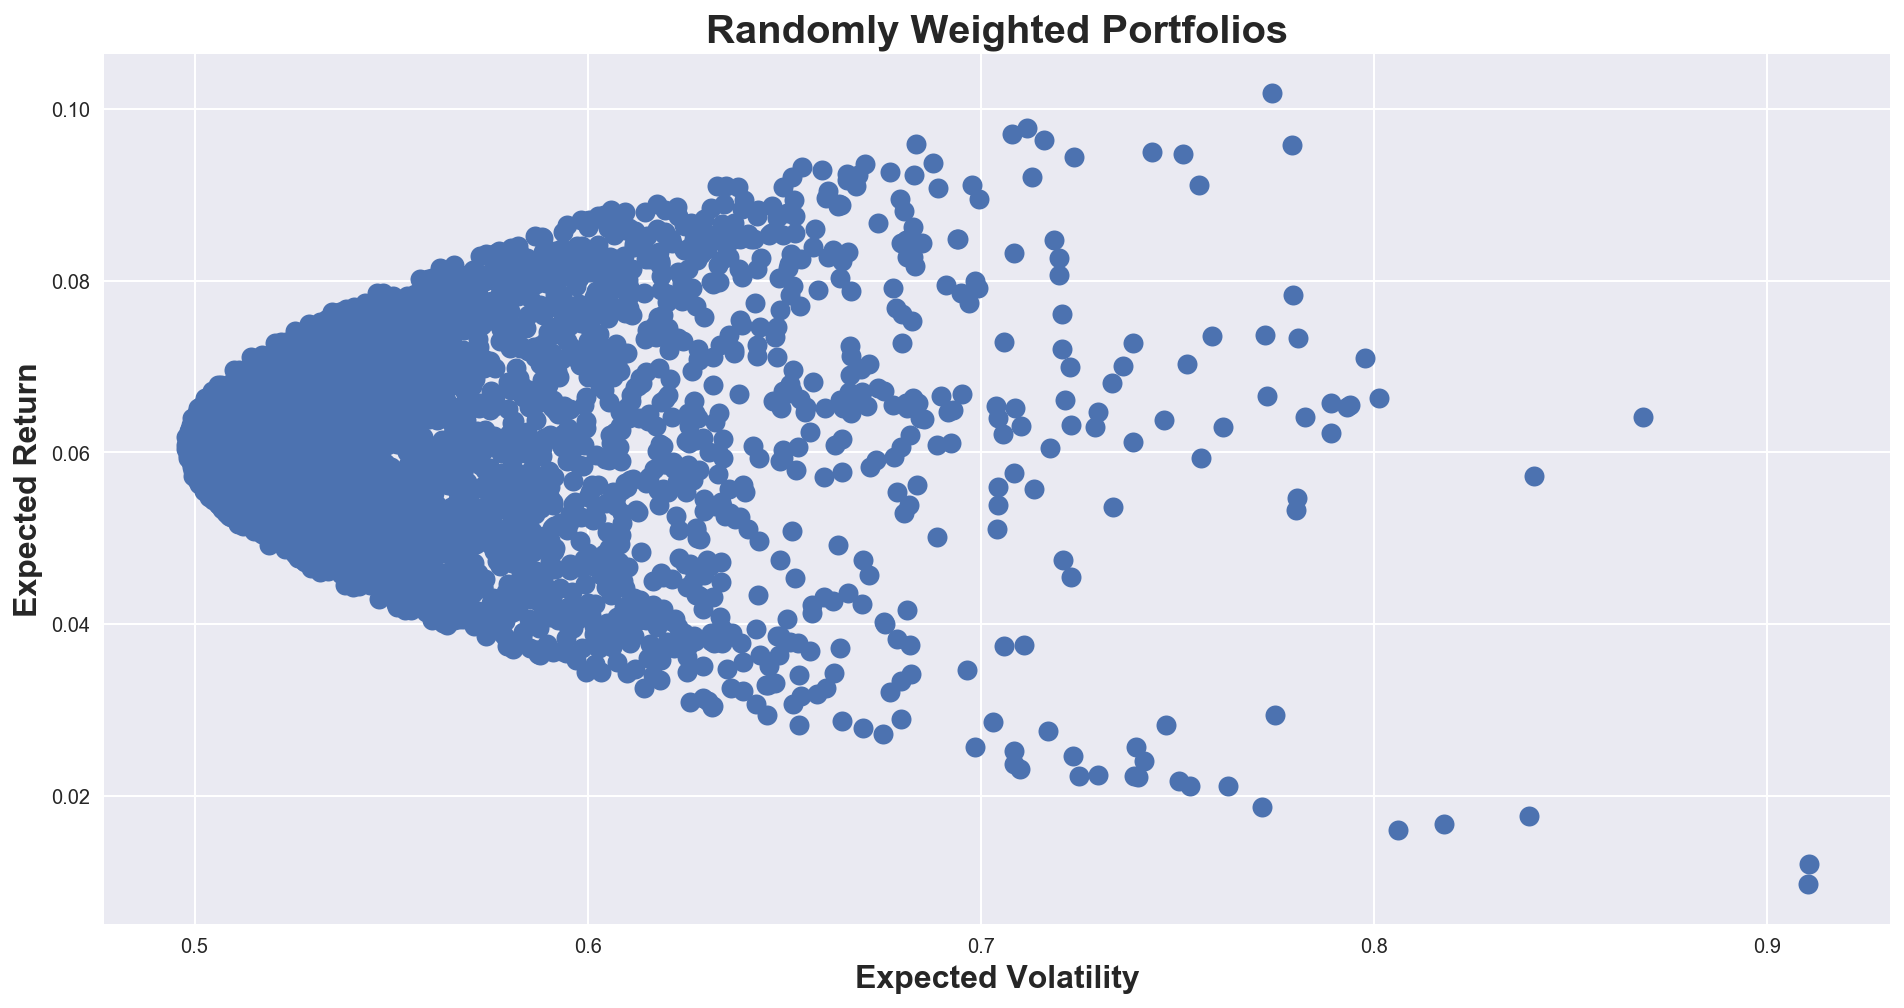

In [208]:
# scatter plot for expected return and volatility
plt.plot(pf_sigmas, pf_mus, 'o', markersize=10)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Randomly Weighted Portfolios')
plt.show()

# Part 3: Efficient Market Frontier 

Portfolio theory in a nutshell is finding the optimal weights that maximize the return given a level of risk (variance or standard deviation) or the other way around, minimize the risk given an expected return. Our minimization problem has the form

\begin{align}
\min{\omega} \quad \omega^T \Sigma \omega \quad \text{s.t.} \quad \mu = \omega^T \mu^* \quad \text{and} \quad \omega^T \mathbf{1} = 1
\end{align}

which can be solved using quadratic programming.


## Quadratic Programming

Quadratic programming (QP) is the process of solving a special type of mathematical optimization problem—specifically, a (linearly constrained) quadratic optimization problem, that is, the problem of optimizing (minimizing or maximizing) a quadratic function of several variables subject to linear constraints on these variables.

Quadratic programming is handily implemented within the module <code>cvxopt</code> which will be used in the latter. The official documentation as well as <a href="https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf">these notes</a> will help you get started with the package. For those who have trouble (like me) installing the <code>cvxopt</code> module will find this <a href="https://stackoverflow.com/questions/17905460/problems-on-installing-cvxopt">Stackoverflow link</a> helpful. Essentially, you will need to install the <code>numpy</code> distribution provided by <a href="https://www.lfd.uci.edu/~gohlke/pythonlibs/">this</a> site.

In [189]:
import cvxopt as opt
from cvxopt import solvers

def calculate_efficient_frontier(returns):
    '''
    returns optimal portfolio weights and corresponding sigmas for a desired optimal portfolio return
    Params:
    - returns: T x N matrix of observed data
    '''
    returns = pd.DataFrame(returns)
    cov = np.matrix(np.cov(returns.T))
    N = returns.shape[1]
    pbar = np.matrix(returns.mean())
    
    # define list of optimal / desired mus for which we'd like to find the sigmas
    opt_mus = []
    r_min = pbar.mean()    # minimum expected return
    for i in range(50):
        opt_mus.append(r_min)
        r_min += (pbar.mean() / 100)
    
    # constraint matrices for quadratic programming
    P = opt.matrix(cov)
    q = opt.matrix(np.zeros((N, 1)))
    G = opt.matrix(np.concatenate((-np.array(pbar), -np.identity(N)), 0))
    A = opt.matrix(1.0, (1,N))
    b = opt.matrix(1.0)
    
    # calculate portfolio weights, every weight vector is of size Nx1
    opt.solvers.options['show_progress'] = False
    # find optimal weights with qp(P, q, G, h, A, b)
    opt_weights = [solvers.qp(P, q, G, opt.matrix(np.concatenate((-np.ones((1, 1)) * mu, np.zeros((N, 1))), 0)), A, b)['x'] for mu in opt_mus]
    # \sigma = w^T * Cov * w
    opt_sigmas = [np.sqrt(np.matrix(w).T * cov.T.dot(np.matrix(w)))[0,0] for w in opt_weights]
    
    return opt_weights, opt_mus, opt_sigmas

For a given list of optimal portfolio returns <code>opt_mus</code> the corresponding optimal portfolio weights are calculated which are used to derive the optimal corresponding volatility. <code>opt_sigmas</code> is calculated as before like $\sigma  = \sqrt{\omega^T \Sigma \omega}$

## Simulated Data

With the simulated data generated earlier we can find the optimal portfolios for a given time series

In [216]:
# calculate mus and sigmas for all and the optimal portfolios
pf_mus, pf_sigmas = create_random_portfolios(return_vec, n_portfolios=3000)
opt_weights, opt_mus, opt_sigmas = calculate_efficient_frontier(return_vec)

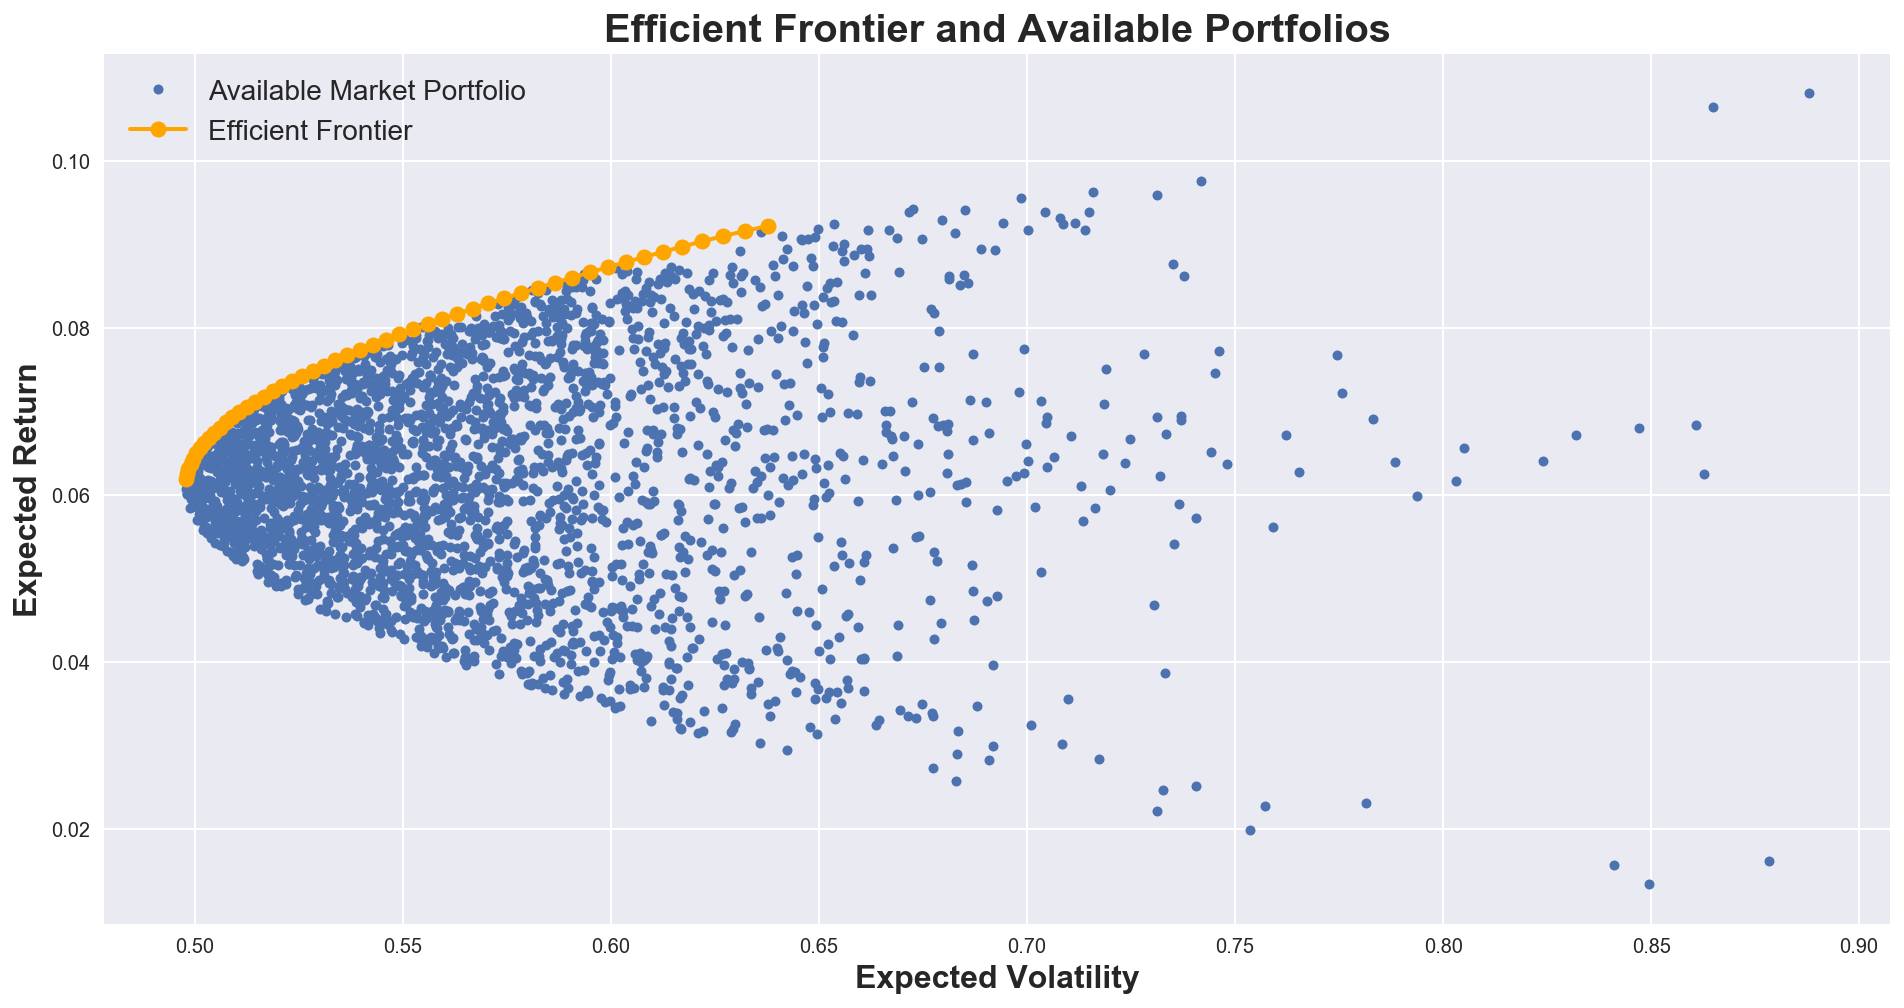

In [217]:
plt.plot(pf_sigmas, pf_mus, 'o', markersize=5, label='Available Market Portfolio')
plt.plot(opt_sigmas, opt_mus, 'y-o', color='orange', markersize=8, label='Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Available Portfolios')
plt.legend(loc='best')
plt.show()

## Real data

In [ ]:
data = pd.read_csv('./data/data_sp100.csv', sep=';', index_col=0, header=0, parse_dates=True)

In [ ]:
companies = ['GOOGL', 'MSFT', 'AMZN', 'AAPL', 'WMT', 'PG', 'GM']

In [ ]:
returns = data[companies] / data[companies].shift(1) - 1
returns = returns.fillna(method='ffill').dropna()

In [222]:
pf_mus, pf_sigmas = create_random_portfolios(returns, n_portfolios=3000)

In [223]:
opt_weights, opt_mus, opt_sigmas = calculate_efficient_frontier(returns)

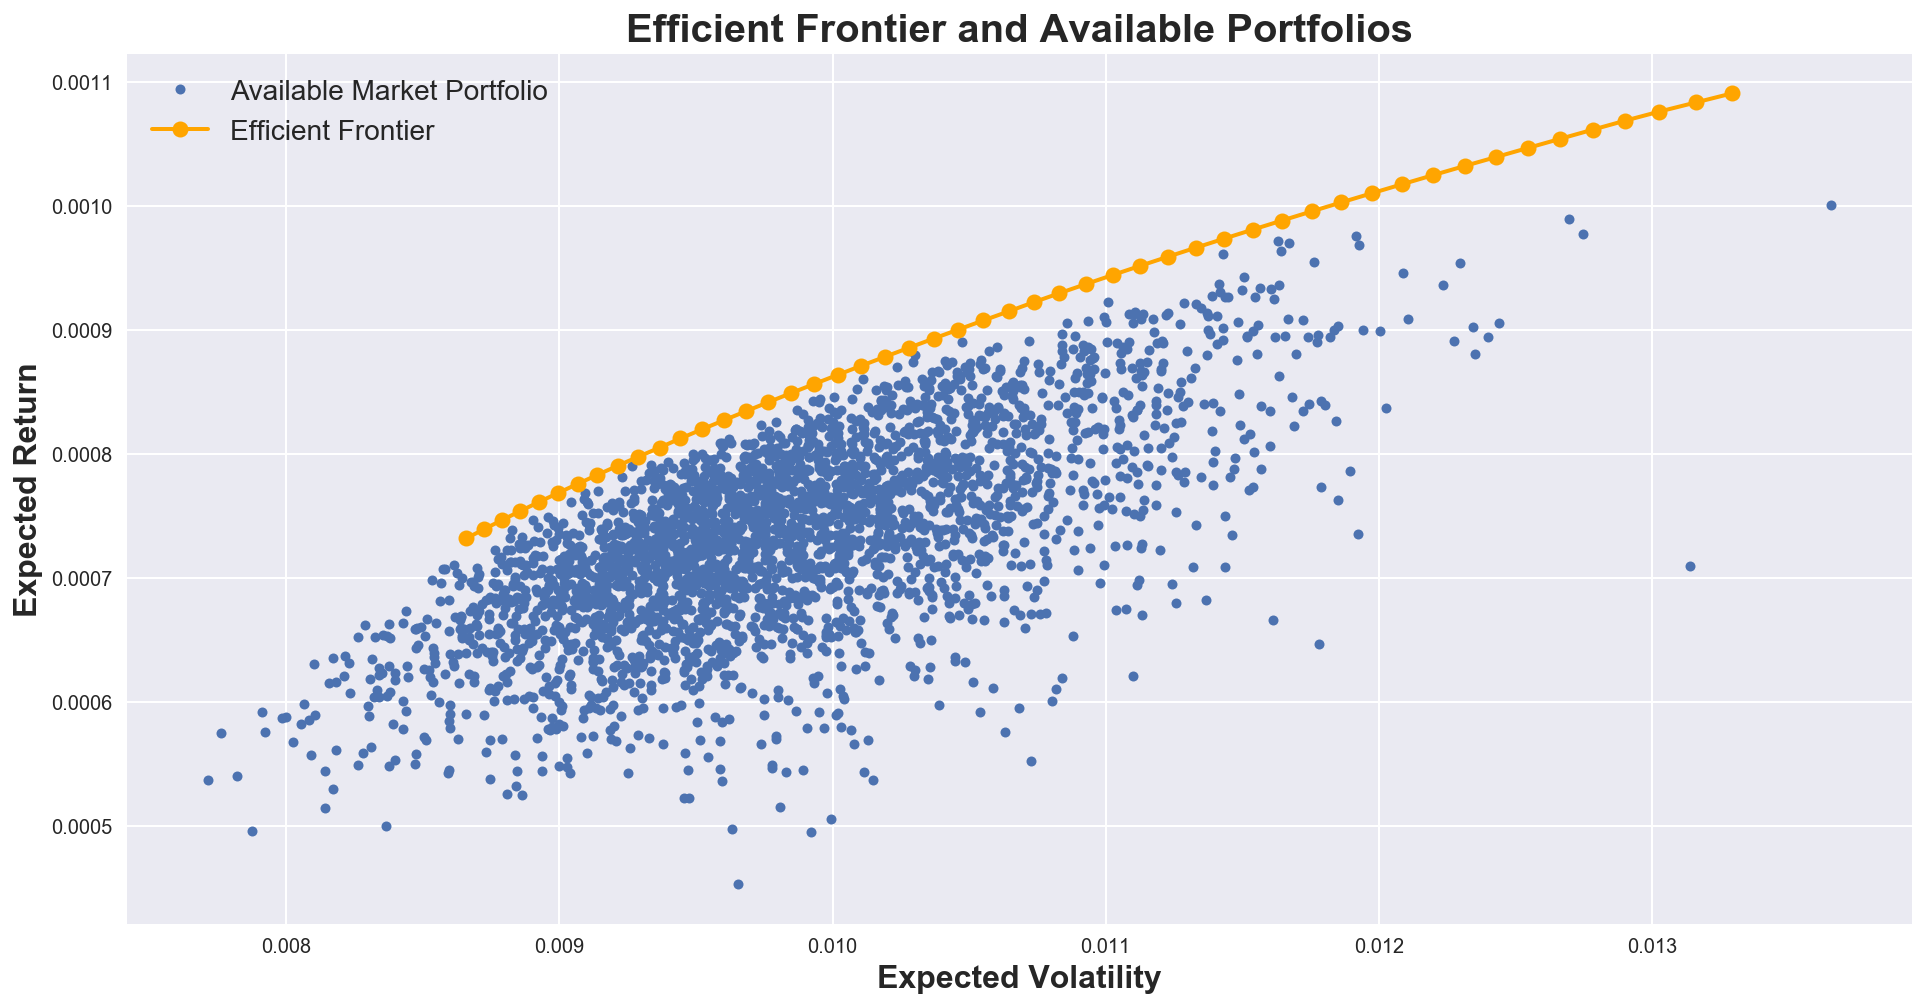

In [214]:
plt.plot(pf_sigmas, pf_mus, 'o', markersize=5, label='Available Market Portfolio')
plt.plot(opt_sigmas, opt_mus, 'y-o', color='orange', markersize=8, label='Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Available Portfolios')
plt.legend(loc='best')
plt.show()

Why are the results visually differing so much between the artificial and the real data? This results from the fact that the model assumes independence and normaility of the observed data. This assumption, however, is not realistic when dealing with real market data, we'd rather assume that the data is close to the normal distribution with occasionally more density mass in the tails of the distribution. This corresponds to more frequent extreme events than under the assumption of normality.

# Part 4: The Capital Asset Pricing Model

The capital asset pricing model (CAPM) is a model that describes the relationship between systematic risk and expected return for assets, particularly stocks. ~ <a href="https://www.investopedia.com/terms/c/capm.asp">Investopedia</a>


# Resources

* https://en.wikipedia.org/wiki/Modern_portfolio_theory
* https://en.wikipedia.org/wiki/Quadratic_programming
* https://www.codecogs.com/latex/eqneditor.php
* http://faculty.washington.edu/ezivot/econ424/portfolioTheoryMatrix.pdf
* http://cvxopt.org/userguide/coneprog.html#quadratic-programming
* https://plot.ly/ipython-notebooks/markowitz-portfolio-optimization/
* https://blog.quantopian.com/markowitz-portfolio-optimization-2/
* http://ahmedas91.github.io/blog/2016/03/01/efficient-frontier-with-python/
